# Install Large Files

In [42]:
import os

# Root directory of the project
ROOT_DIR = os.getcwd()

In [43]:
!pip install gdown
import gdown

def check_and_download(url, output, quiet=False):
    if not os.path.isfile(output):
        gdown.download(url, output, quiet)

# Get example model weight
url = 'https://drive.google.com/uc?id=1XjDlMButvwsZsYauUGybhY5aCBA1tBjo'
output = ROOT_DIR + '/snapshots/lego20200717T1532/mask_rcnn_lego_0041.h5'
check_and_download(url, output)
    
# Get dataset 6
url = 'https://drive.google.com/uc?id=1v4gsJ-2B3LQYKul6XNMrYCbZfIW0M1Wb'
output = ROOT_DIR + '/datasets/images6.zip'
check_and_download(url, output)

# Get dateset 22
url = 'https://drive.google.com/uc?id=1ZmavdrcbDyLNiySJlFPSSpz5vABg1vod'
output = ROOT_DIR + '/datasets/images22.zip'
check_and_download(url, output)

DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.


In [ ]:
# Unzip the dataset you want
dataset = 'images6' # or 'images22'
path_to_unzip = ROOT_DIR + '/datasets/' + dataset + '.zip'

# Options: o (overwrite), q (quiet), d (destination)
!unzip -oq $path_to_unzip -d $ROOT_DIR/datasets
!mv $ROOT_DIR/datasets/$dataset/* $ROOT_DIR/datasets/lego/    

# Import Packages

In [44]:
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.lego import lego

# Inference

## Load Configuration

In [45]:
config = lego.LegoConfig()

class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


Configurations:
BACKBONE_FITLERS_CONFIG        {'S2': [64, 64], 'S3': [128, 128], 'S4': [256, 256], 'S5': [512, 512]}
BACKBONE_MRCNN                 resnet18
BACKBONE_RESNET_BASIC_DEFAULT  {'S2': [64, 64], 'S3': [128, 128], 'S4': [256, 256], 'S5': [512, 512]}
BACKBONE_RESNET_BASIC_WIDER    {'S2': [160, 160], 'S3': [320, 320], 'S4': [640, 640], 'S5': [1280, 1280]}
BACKBONE_RESNET_BOTTLE_DEFAULT {'S2': [64, 64, 256], 'S3': [128, 128, 512], 'S4': [256, 256, 1024], 'S5': [512, 512, 2048]}
BACKBONE_RESNET_BOTTLE_WIDER   {'S2': [256, 256, 256], 'S3': [512, 512, 512], 'S4': [1024, 1024, 1024], 'S5': [1024, 1024, 2048]}
BACKBONE_RPN                   resnet18
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                     

## Load Dataset

In [48]:
DATASET = "eval"
# LEGO_DIR = os.path.join(ROOT_DIR, "datasets", "lego")
LEGO_DIR = os.path.join(ROOT_DIR, "datasets", "personal")

dataset = lego.LegoDataset()
dataset.load_lego(LEGO_DIR, DATASET)
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 2
Classes: ['BG', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']


## Load Model and Weights

In [49]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Comment out to use snapshot from latest training
LEGO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "snapshots", "lego20200717T1532","mask_rcnn_lego_0041.h5")

model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
print("Loading weights ", LEGO_WEIGHTS_PATH)
model.load_weights(LEGO_WEIGHTS_PATH, by_name=True)

Loading weights  /Users/achar/ws/lego-cnn/snapshots/lego20200717T1532/mask_rcnn_lego_0041.h5
Re-starting from epoch 41


# RPN Analysis

In [50]:
if DATASET == "eval":
    # image_id = dataset.get_image_id("0000000002.png") # If eval set us the image with the Lego haufen
    image_id = dataset.get_image_id('IMG_1778.png')
else:
    image_ids = np.random.choice(dataset.image_ids, 1)
    image_id = image_ids[0]
    
image, image_meta, gt_class_ids, gt_bboxes, gt_masks = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

In [51]:
# Run RPN sub-graph
if config.USE_RPN_ROIS:
    pillar = model.keras_model.get_layer("ROI").output

    # TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
    if nms_node is None:
        nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
    if nms_node is None: #TF 1.9-1.10
        nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

    rpn = model.run_graph([image], [
        ("rpn_class", model.keras_model.get_layer("rpn_class").output),         # Last layer in RPN with the proposed class probabilites for background or foreground per anchor
        ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
        ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
        ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
        ("post_nms_anchor_ix", nms_node),                                       # Filtered anchors that have a NMS of RPN_NMS_THRESHOLD (>0.7)
        ("proposals", model.keras_model.get_layer("ROI").output),               # "ROI" is the name of the ProposalLayers, the filtered rois proposals
    ], config)

rpn_class                shape: (1, 172887, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.21783  max:    1.14082  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.20493  max:    1.15718  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (105,)                min:    0.00000  max: 5927.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


Best proposals are:

Proposal Bbox 0: 	[107 175 198 252] w=91 h=77 iou=0.68
Proposal Bbox 1: 	[357 131 460 242] w=102 h=112 iou=0.90
Proposal Bbox 2: 	[134 355 216 418] w=83 h=63 iou=0.80
Proposal Bbox 3: 	[261 301 364 405] w=103 h=105 iou=0.89
Proposal Bbox 4: 	[94 455 179 537] w=84 h=82 iou=0.69
Proposal Bbox 5: 	[196 532 314 638] w=119 h=106 iou=0.74
Proposal Bbox 6: 	[515 584 597 691] w=82 h=107 iou=0.86

Average maximum IoU is: 0.80


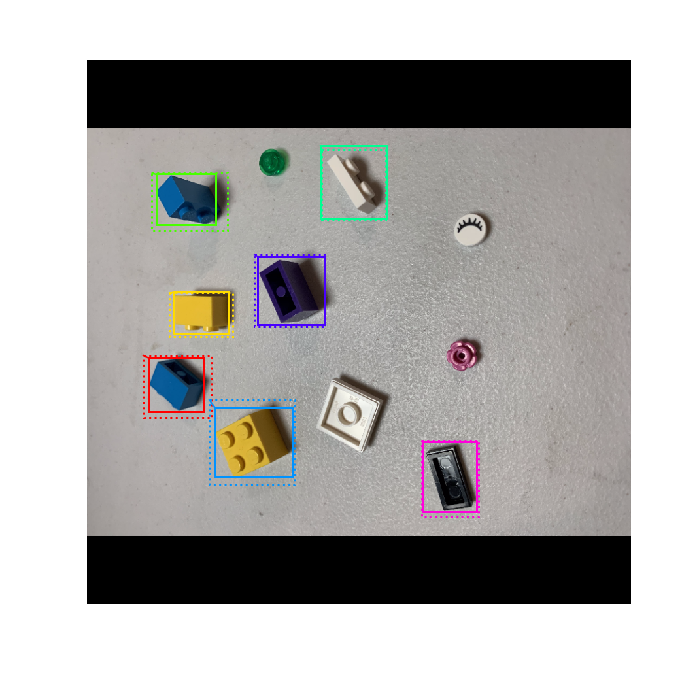

In [52]:
# Find the proposal that has the highest IoU on each GT box and take average of all
max_proposals_bbox = np.empty((gt_bboxes.shape[0], 4))
max_proposals_iou = np.empty((gt_bboxes.shape[0], 1))

# Get proposals from graph
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :] * np.array([h, w, h, w])

print("Best proposals are:\n")
for i, box in enumerate(gt_bboxes):

    overlaps = utils.compute_overlaps(np.array([box.tolist()]), proposals)
    iou_max = np.max(overlaps, axis=1)
    iou_argmax = np.argmax(overlaps, axis=1)
    max_proposals_bbox[i] = proposals[iou_argmax]
    max_proposals_iou[i] = iou_max

    y1, x1, y2, x2 = proposals[iou_argmax][0]
    iou = iou_max[0]

    print("Proposal Bbox {}: \t[{:.0f} {:.0f} {:.0f} {:.0f}] w={:.0f} h={:.0f} iou={:.2f}".format(i, x1, y1, x2, y2, x2-x1, y2-y1, iou))


print("\nAverage maximum IoU is: {0:0.2f}".format(np.average(max_proposals_iou)))
visualize.draw_boxes(image, boxes=gt_bboxes, refined_boxes=max_proposals_bbox)

TP:  1   FP:  9   TP/FP: 0.1   TP/Total: 12%
mAP@0.5:  0.5


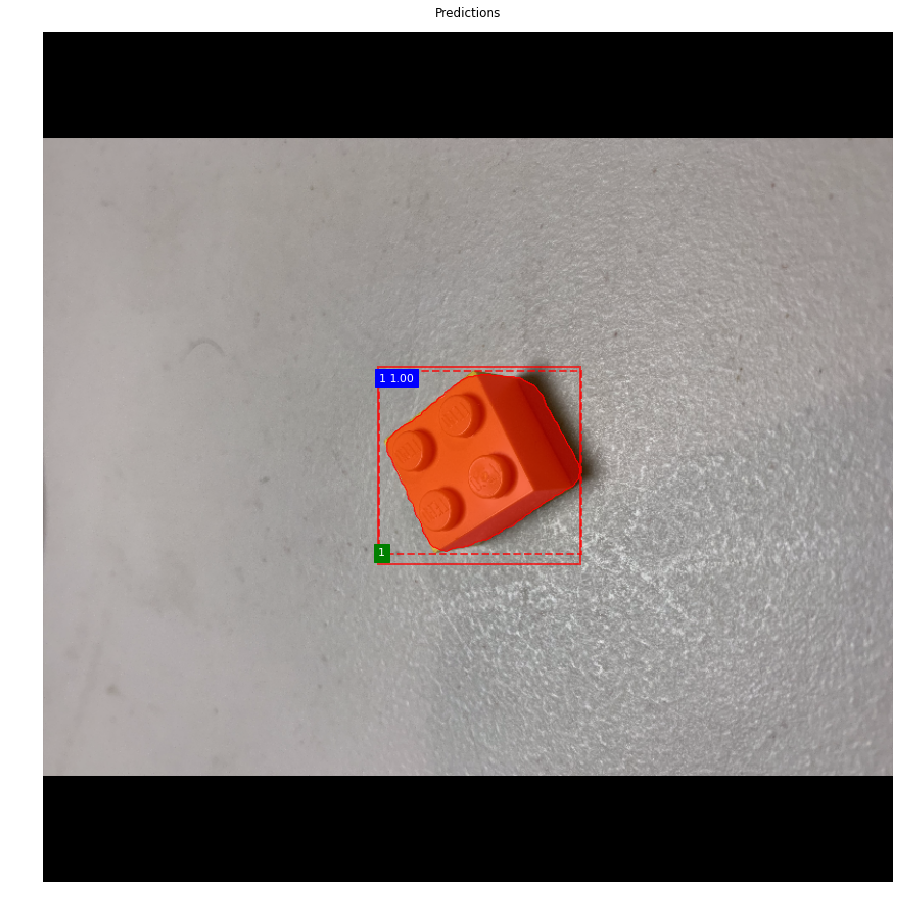

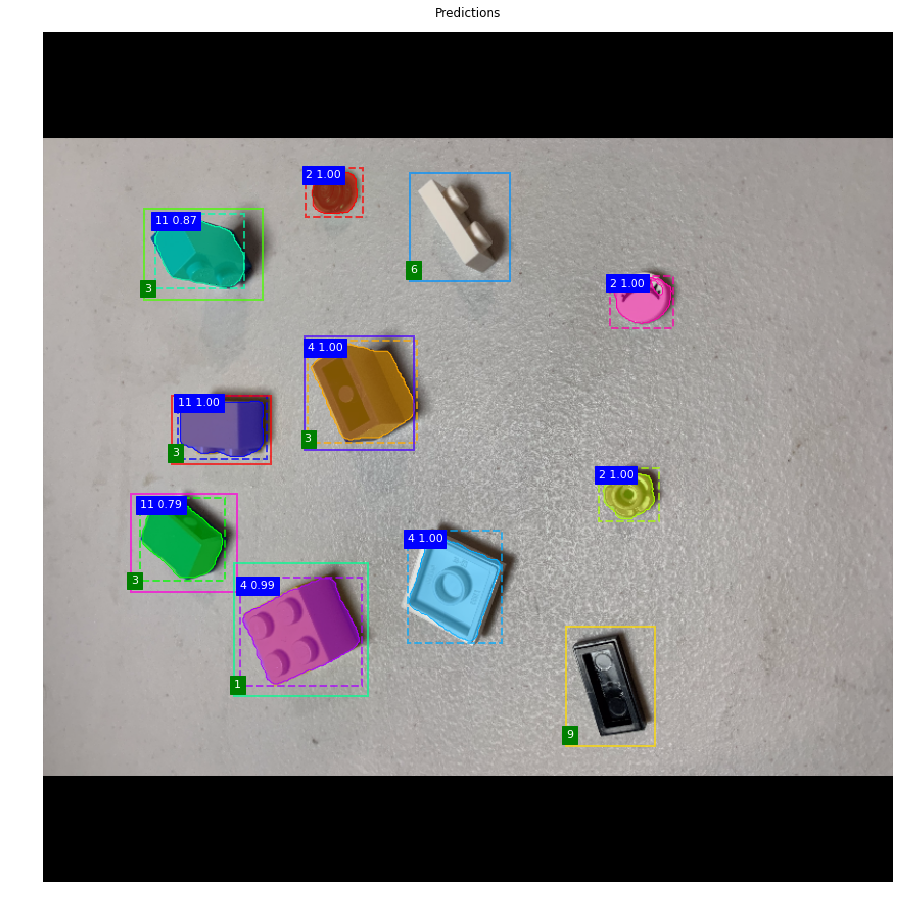

In [53]:
# Compute VOC-Style mAP @ IoU=0.5
APs = []
TPs = []
FPs = []
total_instances = 0

# IoU threshold to determine a postive match
mAP_IOU_THRESHOLD = 0.5

if DATASET == "eval":
    image_ids = dataset.image_ids
else:
    image_ids = np.random.choice(dataset.image_ids, 5 if config.USE_STAGE_TWO else 1)

for image_id in image_ids:

    # Load image and ground truth data
    image, image_meta, gt_class_ids, gt_bboxes, gt_masks =  modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

    # Run object detection
    results = model.detect([image], gt_class_ids, gt_bboxes, gt_masks, verbose=0)
    r = results[0]

    ax = get_ax(1)
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, gt_bboxes, gt_class_ids, 
                                r['scores'], ax=ax, title="Predictions")

    # Compute AP, IoU ist mit den Masken berechnet, nicht mit Bboxen
    AP, precisions, recalls, overlaps, true_positives, false_positives = utils.compute_ap(  gt_bboxes, gt_class_ids, gt_masks,    
                                                                                            r["rois"], r["class_ids"], r["scores"], r['masks'],
                                                                                            iou_threshold=mAP_IOU_THRESHOLD)
    if true_positives == 0 and false_positives == 0:
        print("\n*** No instances matched in {} *** \n".format(dataset.image_info[image_id]["id"]))
        
    APs.append(AP)
    TPs.append(true_positives)
    FPs.append(false_positives)
    total_instances += len(gt_bboxes)

tps = int(np.sum(TPs))
fps = int(np.sum(FPs))

print('TP: {:2.0f}   FP: {:2.0f}   TP/FP: {:2.1f}   TP/Total: {:2.0f}%'.format(tps, fps, 0 if fps == 0 else (tps/fps), 0 if total_instances == 0 else (100.0/total_instances)*tps))
print("mAP@" + str(mAP_IOU_THRESHOLD)+ ": ", np.mean(APs))